In [3]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize']=[8,6]

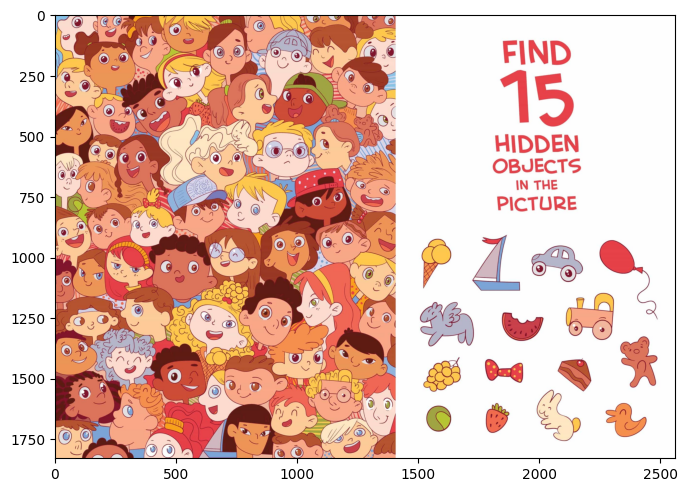

In [4]:
# hiển thị ảnh
img1_global = cv2.imread('./Finding/1.jpg')
plt.imshow(img1_global[:,:,::-1])
# plt.axis('off')

# Find template

In [5]:
# phương pháp Contours

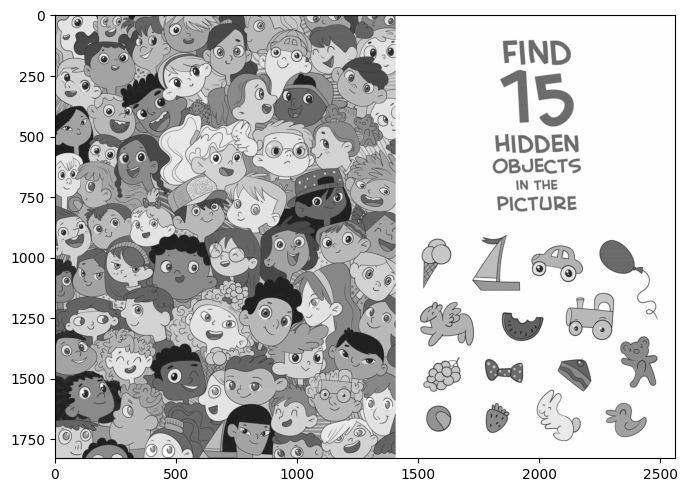

In [6]:
# đưa về ảnh xám 
img1_gray = cv2.cvtColor(img1_global, cv2.COLOR_BGR2GRAY).astype(np.float32)
plt.imshow(img1_gray, cmap='gray')

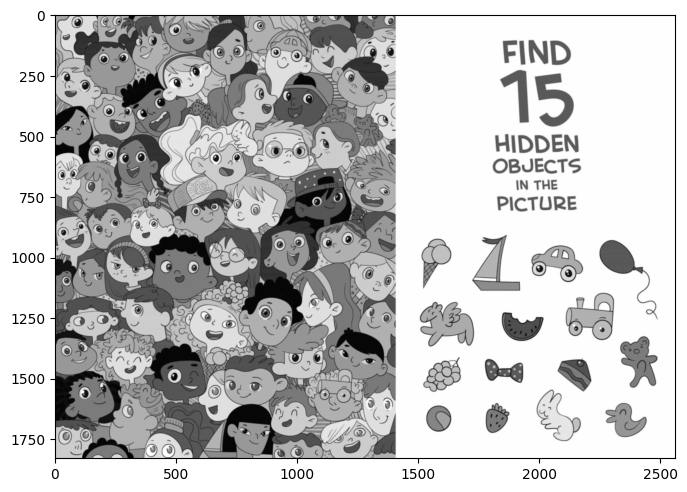

In [ ]:
# Làm mờ ảnh để giảm nhiễu
blur = cv2.GaussianBlur(img1_gray, (5, 5), 0)
plt.imshow(blur, cmap='gray')

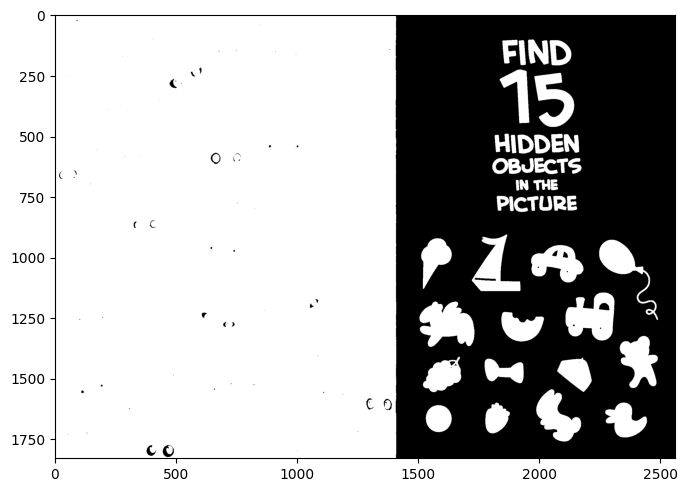

In [8]:
# Áp dụng ngưỡng nhị phân đảo
_, threshold = cv2.threshold(blur, 245, 255, cv2.THRESH_BINARY_INV)
threshold = threshold.astype(np.uint8)
plt.imshow(threshold, cmap='gray')

In [9]:
# Tìm đường viền của đối tượng
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

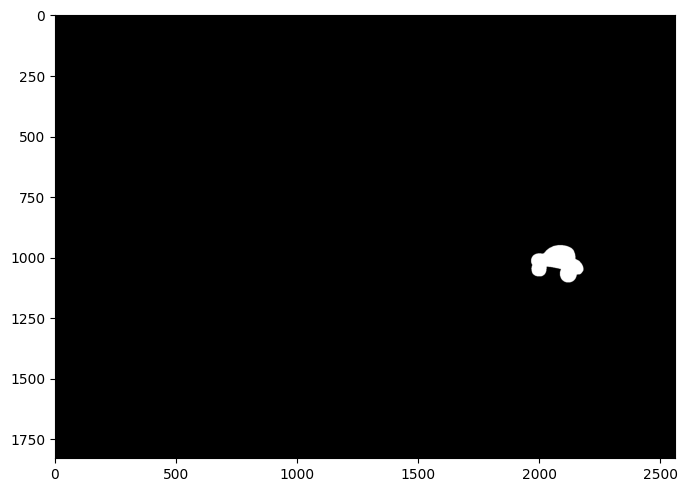

In [10]:
# vẽ từng đối tượng lên nền đen
mask = np.zeros_like(img1_global, dtype=np.uint8)
cv2.drawContours(mask, [contours[12]], -1, (255, 255, 255), thickness=cv2.FILLED)
plt.imshow(mask, cmap='gray')

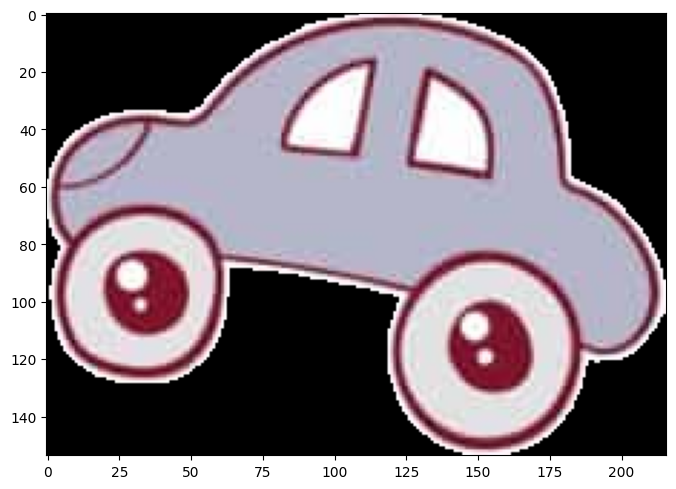

In [11]:
# Áp dụng mask để tách đối tượng
object_image = cv2.bitwise_and(img1_global, mask)

# Cắt đối tượng theo bounding box
x, y, w, h = cv2.boundingRect(contours[12])
# object_image_cropped = object_image[y:y+h, x:x+w]
object_image_cropped = object_image[y:y+h, x:x+w]

plt.imshow(object_image_cropped[:,:,::-1])

In [4]:
# tổng hợp các bước
def get_contours(img, closing=False, white=False):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

    blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    _, threshold = cv2.threshold(blur, 245, 255, cv2.THRESH_BINARY_INV)
    threshold = threshold.astype(np.uint8)
    
    if closing:
        kernel = np.ones((5, 5), np.uint8)
        closed = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
        contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else: 
        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    template_arr = []
    for contour in contours:
        # Bỏ qua các vùng quá nhỏ (nhiễu)
        if cv2.contourArea(contour) < 500:
            continue

        # vẽ từng đối tượng
        mask = np.zeros_like(img, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

        # tách từng đối tượng
        object_image = cv2.bitwise_and(img, mask)
        x, y, w, h = cv2.boundingRect(contour)
        object_image_cropped = object_image[y:y+h, x:x+w]

        if white:
            # chuyển nền đen thành trắng
            object_image_cropped[object_image_cropped == 0] = 255
        
        template_arr.append(object_image_cropped)

    return template_arr

In [13]:
template_arr = get_contours(img1_global)

In [5]:
def get_template (template_arr):
    # Xác định số hàng và cột dựa trên số lượng ảnh
    num_images = len(template_arr)
    cols = 8  # Số cột cố định
    rows = math.ceil(num_images/cols)   # Làm tròn lên

    # Tạo figure và các subplot
    fig, axis = plt.subplots(rows, cols, figsize=(cols, rows))

    # Đảm bảo axis là một mảng 2D
    axis = axis.reshape(rows, cols)

    # Vẽ từng ảnh vào ô tương ứng
    for i, t in enumerate(template_arr):
        row, col = divmod(i, cols)  # Phép chia lấy phần nguyên và dư
        axis[row][col].imshow(t[:,:,::-1])  # Chuyển BGR → RGB
        axis[row][col].axis('off')  # Ẩn trục
        axis[row][col].set_title(f'Object {i}')

    # Ẩn các ô trống nếu số ảnh không chia hết cho số cột
    for j in range(i + 1, rows * cols):
        row, col = divmod(j, cols)
        axis[row][col].axis('off')

    plt.tight_layout()  # Căn chỉnh layout đẹp hơn
    plt.show()


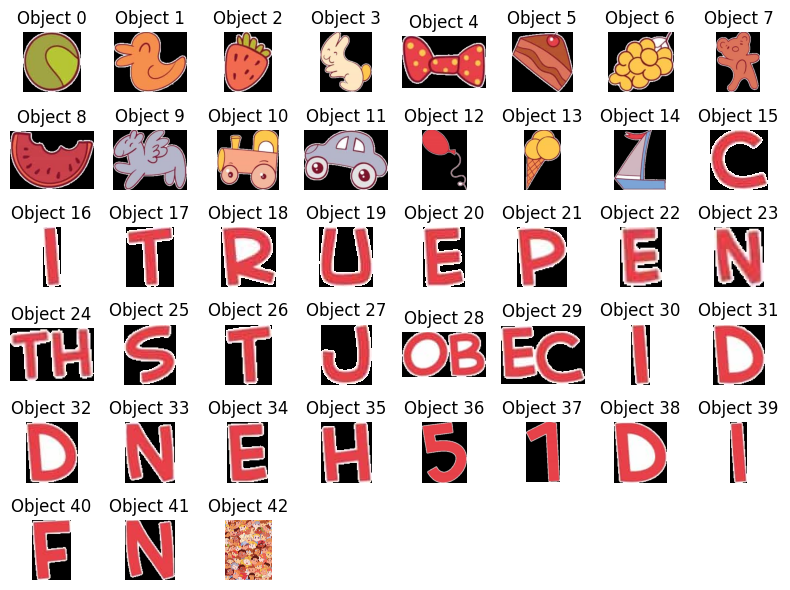

In [15]:
get_template(template_arr)

# Normalized cross-correlation

In [16]:
# chuẩn hóa theo độ sáng và độ tương phản(-1 đến 1)
# phụ thuộc vào cấu trúc của ảnh

Công thức:
$$
NCC(I, T) = \frac{\sum_{i,j} \left(I(x+i,y+j) - \bar{I}\right)\left(T(i,j) - \bar{T}\right)}
{\sqrt{\sum_{i,j}\left(I(x+i,y+j) - \bar{I}\right)^2 \, \sum_{i,j}\left(T(i,j) - \bar{T}\right)^2}}
\\ = \frac{correlation}{image\_ std \times template \_ std}
$$

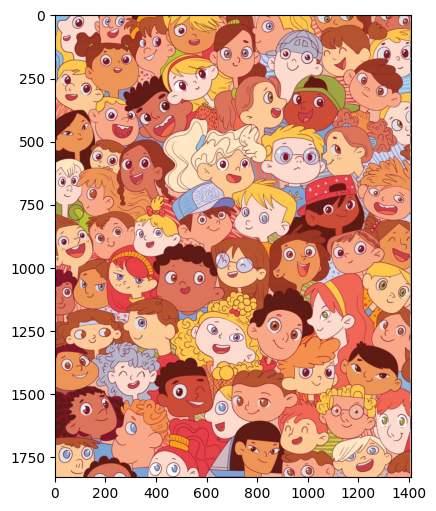

In [17]:
img = template_arr[42]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)

plt.imshow(img[:,:,::-1])

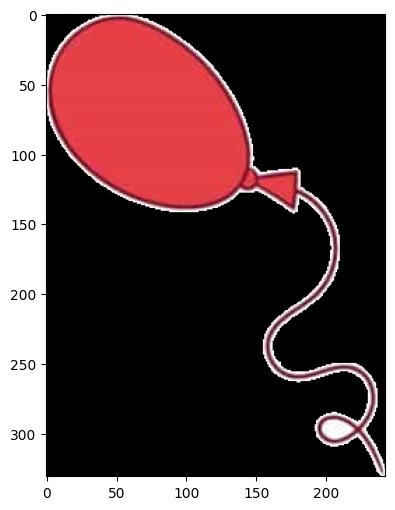

In [18]:
template = template_arr[12]
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY).astype(np.uint8)

plt.imshow(template[:,:,::-1])

In [19]:
def get_ncc (img, template):
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
    else:
        img = img.astype(np.float32)
        
    if len(template.shape) == 3 and template.shape[2] == 3:
        template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY).astype(np.float32)
    else:
        template = template.astype(np.float32)

    h, w = template.shape[:2]
    
    #tạo kernel để tính trung bình từng vùng của image
    kernel = np.ones(template.shape[:2], dtype=np.float32) / (h * w)
    img_local_mean = cv2.filter2D(img, -1, kernel)
    img_local_deviation = img - img_local_mean
    
    template_mean = np.mean(template)
    template_deviation = template - template_mean

    # correlation
    correlation = cv2.filter2D(img_local_deviation, -1, template_deviation)

    img_local_deviation_sq = img_local_deviation ** 2
    img_local_variance = cv2.filter2D(img_local_deviation_sq, -1, kernel)
    img_local_std = np.sqrt(img_local_variance)
    epsilon = 1e-5

    # std
    img_local_std = np.where(img_local_std < epsilon, epsilon, img_local_std) # tránh chia 0
    template_std = np.std(template)

    # ncc
    ncc = correlation / (img_local_std * template_std)
    return ncc

In [20]:
def check(convolved_img, img, template):
    copy_img = img.copy()

    # vị trí của pixel có giá trị lớn nhất
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(convolved_img)
    
    top_left = max_loc # (x,y)

    h, w = template.shape[:2]
    img_h, img_w = img.shape[:2]

    # Tính toán tọa độ vùng cắt, đảm bảo nằm trong ảnh
    x_start = max(0, top_left[0] - int(w/2)) # Không nhỏ hơn 0
    y_start = max(0, top_left[1] - int(h/2)) # Không nhỏ hơn 0
    x_end = min(img_w, x_start + w) # Không vượt quá chiều rộng ảnh
    y_end = min(img_h, y_start + h) # Không vượt quá chiều cao ảnh

    # Cắt vùng từ ảnh gốc
    answer = img[y_start:y_end, x_start:x_end]

    copy_convolved_img = convolved_img.copy()
    copy_convolved_img = cv2.normalize(copy_convolved_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8') # chuẩn hóa
    copy_convolved_img = cv2.cvtColor(copy_convolved_img, cv2.COLOR_GRAY2BGR) # chuyển sang ảnh màu

    # đánh dấu vị trí trung tâm
    center = (top_left[0], top_left[1])
    radius = 100
    green = (0,255,0)
    thickness = 12

    # vẽ hình tròn
    cv2.circle(copy_convolved_img, center, radius, green, thickness)

    plt.subplot(2,2,1), plt.imshow(copy_convolved_img[:,:,::-1]), plt.title("Convolved Image"), plt.axis('off')
    plt.subplot(2,2,2), plt.imshow(copy_img[:,:,::-1]), plt.title("Image"), plt.axis('off')
    plt.subplot(2,2,3), plt.imshow(template[:,:,::-1]), plt.title("Template"), plt.axis('off')
    plt.subplot(2,2,4), plt.imshow(answer[:,:,::-1]), plt.title("Answer"), plt.axis('off')
    plt.tight_layout()
    plt.show()

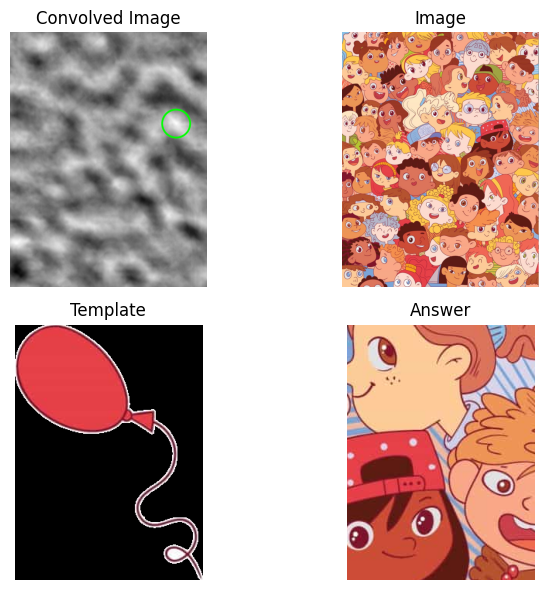

In [21]:
ncc = get_ncc(img, template)
check(ncc, img, template)

In [22]:
# vì template có nhiều giá trị nền gây nhiễu (đen hoặc trắng)
# phát hiện cạnh để tập trung vào đối tượng hơn, sử dụng canny

# Canny

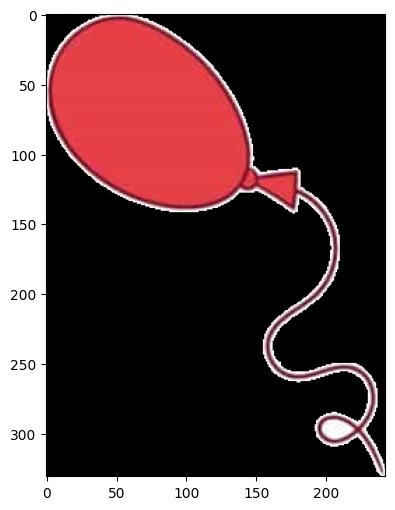

In [23]:
template = template_arr[12]
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY).astype(np.uint8)

plt.imshow(template[:,:,::-1])

(<Axes: >,
 (np.float64(-0.5), np.float64(242.5), np.float64(330.5), np.float64(-0.5)))

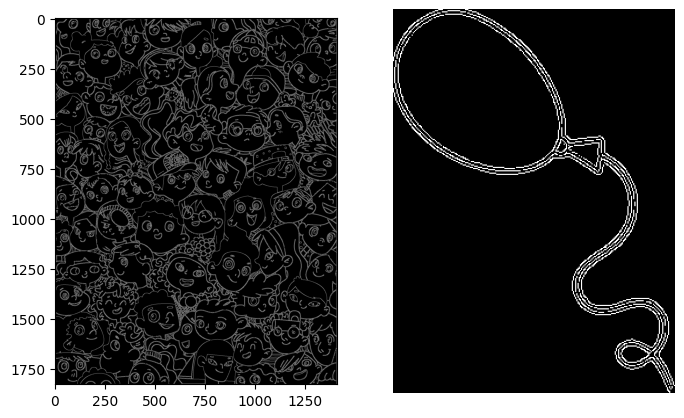

In [24]:
img_edges = cv2.Canny(img_gray, threshold1=100, threshold2=200).astype(np.float32)
template_edges = cv2.Canny(template_gray, threshold1=100, threshold2=200).astype(np.float32)
plt.subplot(1,2,1), plt.imshow(img_edges, cmap='gray')#, plt.axis('off')
plt.subplot(1,2,2), plt.imshow(template_edges, cmap='gray'), plt.axis('off')

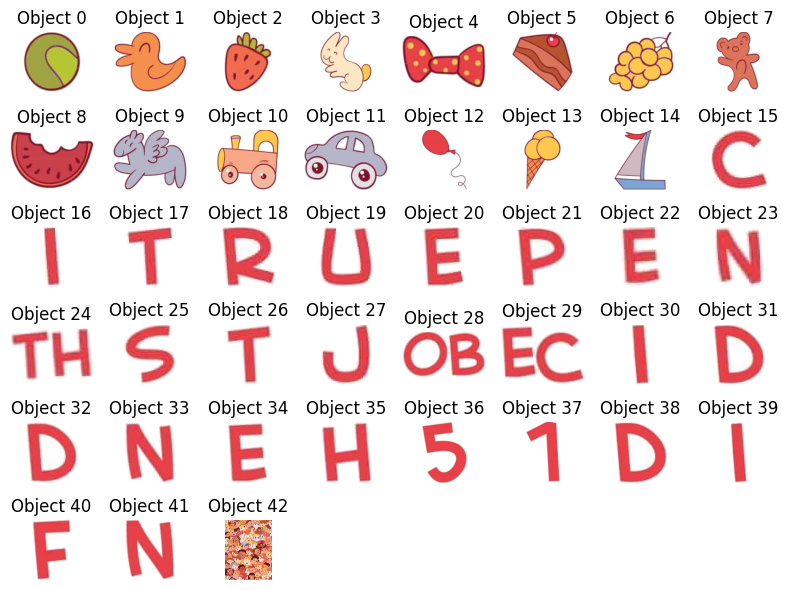

In [25]:
# Canny tạo ra nhiều cạnh (nền đen, viền trắng)
# lấy template với nền trắng
template_arr = get_contours(img1_global, white=True)
get_template(template_arr)

(<Axes: >,
 (np.float64(-0.5), np.float64(242.5), np.float64(330.5), np.float64(-0.5)))

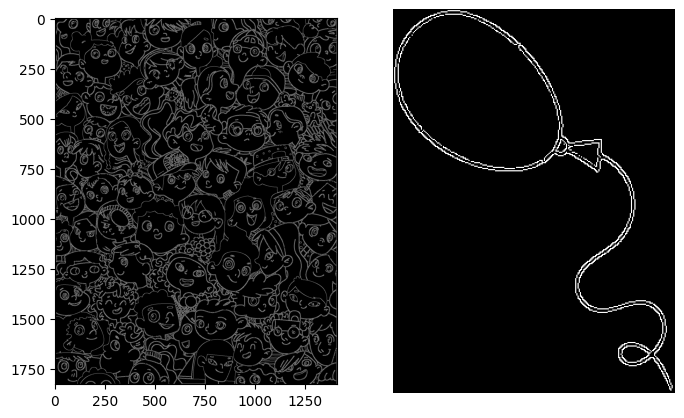

In [26]:
template = template_arr[12]
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY).astype(np.uint8)
img_edges = cv2.Canny(img_gray, threshold1=100, threshold2=200).astype(np.float32)
template_edges = cv2.Canny(template_gray, threshold1=100, threshold2=200).astype(np.float32)
plt.subplot(1,2,1), plt.imshow(img_edges, cmap='gray')#, plt.axis('off')
plt.subplot(1,2,2), plt.imshow(template_edges, cmap='gray'), plt.axis('off')

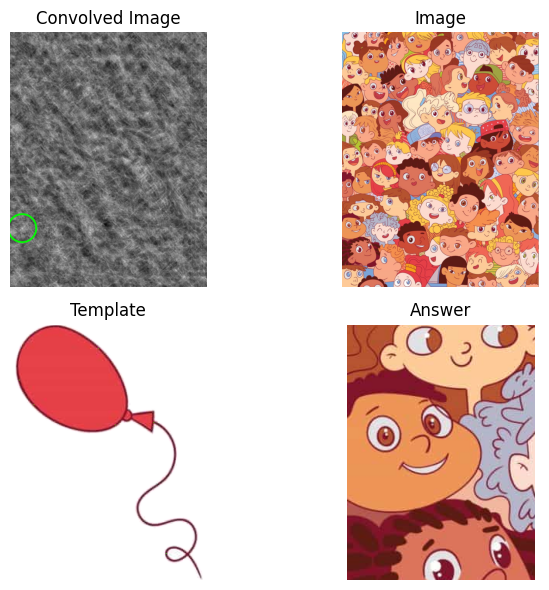

In [27]:
# kiểm tra kết quả
ncc = get_ncc(img_edges, template_edges)
check(ncc, img, template)

In [28]:
# vì template có kích thước khác với đối tượng trong img
# xử lý multi-scale template matching

# Multi-scale template matching

In [29]:
def matching_object(image, template):
    # chuyển về ảnh xám
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # lưu các tham số tốt nhất
    best_max_val = -1
    best_max_loc = None
    best_template = None
    best_scale = 1.0
    best_convolved = None

    # tìm cạnh
    image_edge = cv2.Canny(image_gray, 50, 200).astype(np.float32)

    # multi-scale
    for scale in np.linspace(0.4, 1.0, 61):
        template_resize = cv2.resize(template_gray, None, fx=scale, fy=scale)
        template_edge = cv2.Canny(template_resize, 50, 200).astype(np.float32)
        result = get_ncc(image_edge, template_edge)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)

        # cập nhật tham số
        if max_val > best_max_val:
            best_max_val = max_val
            best_max_loc = max_loc
            best_template = template_resize
            best_scale = scale
            best_convolved = result

    h, w = best_template.shape[:2]
    center = best_max_loc

    # vẽ hình chữ nhật
    top_left = (center[0] - int(w/2), center[1] - int(h/2))
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(image, top_left, bottom_right, (0,255,0), 5)

    return best_convolved, image, best_scale

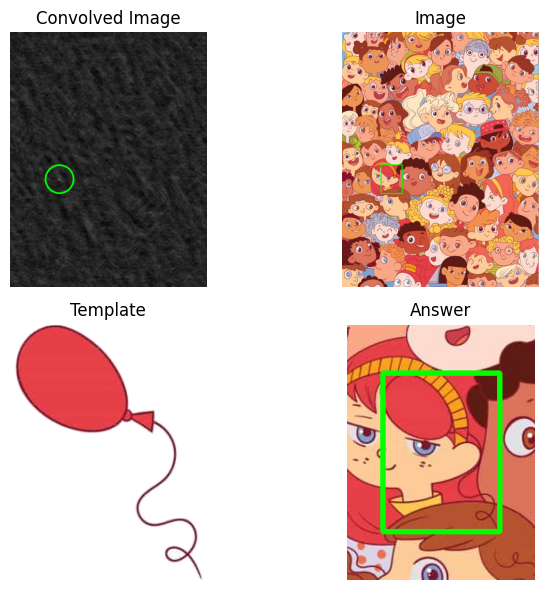

In [30]:
img_copy = img.copy()
ncc, img_copy, _ = matching_object(img_copy, template)
check(ncc, img_copy, template)

C:\Users\admin\AppData\Local\Temp\ipykernel_11744\2724754700.py:27: RuntimeWarning: invalid value encountered in sqrt
  img_local_std = np.sqrt(img_local_variance)


Template0 found with best scale: 0.60
Template1 found with best scale: 0.72
Template2 found with best scale: 0.57
Template3 found with best scale: 0.72
Template4 found with best scale: 0.47
Template5 found with best scale: 0.60
Template6 found with best scale: 0.72
Template7 found with best scale: 0.62
Template8 found with best scale: 0.48
Template9 found with best scale: 0.59
Template10 found with best scale: 0.72
Template11 found with best scale: 0.72
Template12 found with best scale: 0.62
Template13 found with best scale: 0.72
Template14 found with best scale: 0.73


(np.float64(-0.5), np.float64(1408.5), np.float64(1828.5), np.float64(-0.5))

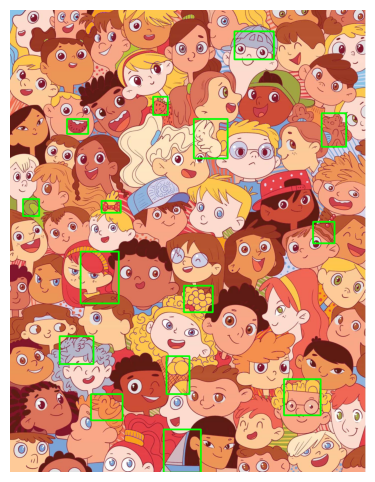

In [31]:
# tìm tất cả các đối tượng
img = template_arr[42]

for i in range(15):
    template = template_arr[i]
    _, img_answer, scale = matching_object(img, template)
    print(f"Template{i} found with best scale: {scale:.2f}")
    
plt.imshow(img_answer[:,:,::-1])
plt.axis('off')

In [32]:
cv2.imwrite('./Finding/1_answer.jpg', img_answer)

True

# Image 2.jpg

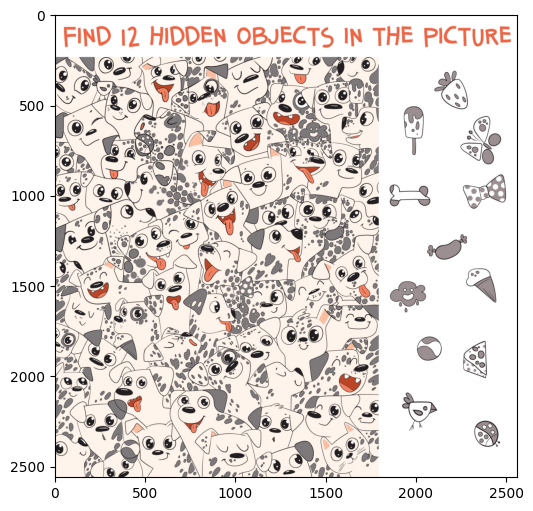

In [33]:
img2_global = cv2.imread('./Finding/2.jpg')
plt.imshow(img2_global[:,:,::-1])

(<Axes: title={'center': 'Template2'}>,
 (np.float64(-0.5), np.float64(759.5), np.float64(2329.5), np.float64(-0.5)),
 Text(0.5, 1.0, 'Template2'))

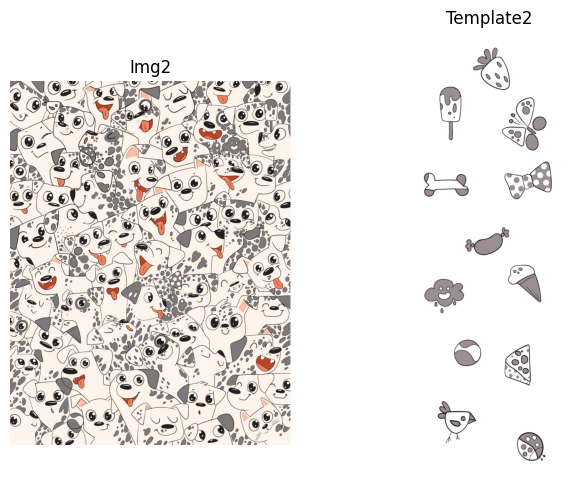

In [34]:
img2 = img2_global[230:, :1800]
template2 = img2_global[230:, 1800:]
plt.subplot(1,2,1) ,plt.imshow(img2[:,:,::-1]),plt.axis('off'), plt.title('Img2')
plt.subplot(1,2,2) ,plt.imshow(template2[:,:,::-1]),plt.axis('off'), plt.title('Template2')

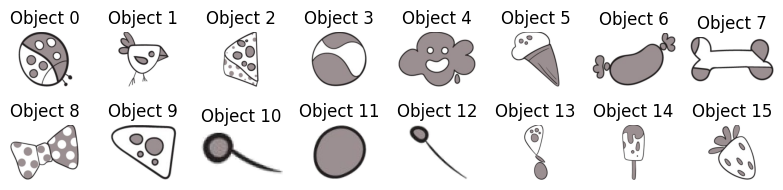

In [35]:
template2_arr = get_contours(template2, white=True)
get_template(template2_arr)

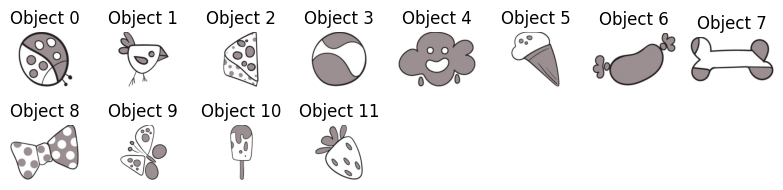

In [36]:
# xử lý đối tượng không liền nhau bằng phép đóng (closing)
template2_arr = get_contours(template2, closing=True, white=True)
get_template(template2_arr)

C:\Users\admin\AppData\Local\Temp\ipykernel_11744\2724754700.py:27: RuntimeWarning: invalid value encountered in sqrt
  img_local_std = np.sqrt(img_local_variance)


Template0 found with best scale: 0.79
Template1 found with best scale: 0.72
Template2 found with best scale: 0.79
Template3 found with best scale: 0.79
Template4 found with best scale: 0.79
Template5 found with best scale: 0.79
Template6 found with best scale: 0.73
Template7 found with best scale: 0.67
Template8 found with best scale: 0.79
Template9 found with best scale: 0.78
Template10 found with best scale: 0.79
Template11 found with best scale: 0.78


(np.float64(-0.5), np.float64(1799.5), np.float64(2329.5), np.float64(-0.5))

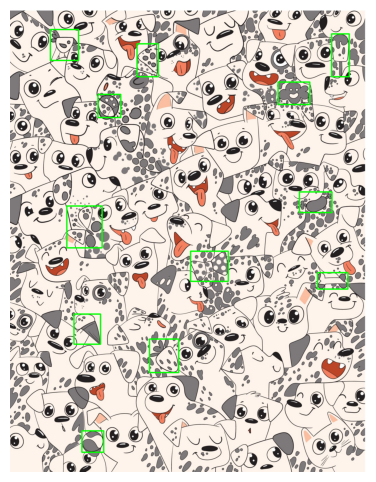

In [37]:
# tìm tất cả các đối tượng
for i in range(len(template2_arr)):
    template2 = template2_arr[i]
    _, img2_answer, scale = matching_object(img2, template2)
    print(f"Template{i} found with best scale: {scale:.2f}")
plt.imshow(img2_answer[:,:,::-1])
plt.axis('off')

In [38]:
cv2.imwrite('./Finding/2_answer.jpg', img2_answer)

True

# Find dice

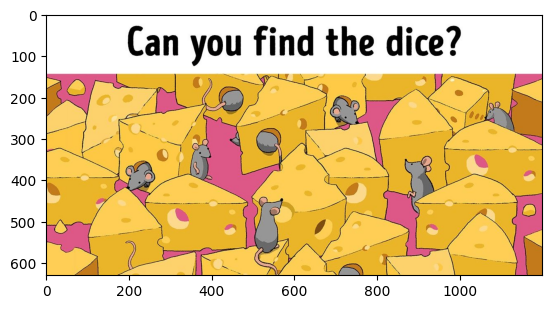

In [4]:
mouse = cv2.imread('./Counting/mouse.jpg')
plt.imshow(mouse[:,:,::-1])

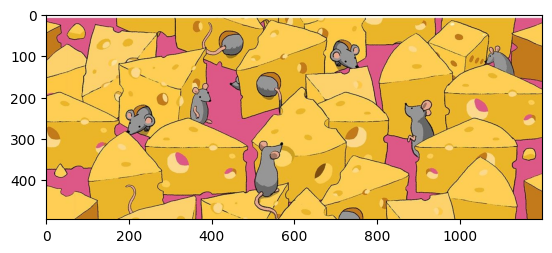

In [5]:
h, w = mouse.shape[:2]
mouse = mouse[135:h,::]
plt.imshow(mouse[:,:,::-1])

In [ ]:
# Giả sử 'contours' là danh sách các contour từ cv2.findContours()
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
    if len(approx) == 4:  # Đa giác có 4 cạnh
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.8 <= aspect_ratio <= 1.2:  # Phạm vi mở rộng
            # Kiểm tra chấm bên trong contour (tùy chọn)
            print("Có thể là xúc xắc")